# The dataset consists of Women’s fashion online shop reviews, consisting of a title, a review text, and whether the review author would recommend the product. The goal is to determine whether a reviewer will recommend a product or not based on review title and review. Such a classifier can help find out what is good or bad about certain products or to highlight more relevant reviews (like a very critical and a very positive one) about certain products.

In [1]:
import numpy as np
import scipy.io as sc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

## 1. Data loading and pre-processing

In [2]:
trainDat = pd.read_csv("data_train.csv")
testDat = pd.read_csv("data_test.csv")

In [3]:
print(trainDat.shape)
print(testDat.shape)

(17614, 3)
(5872, 3)


In [4]:
trainDat.head(n=10)

,Title,Review,Recommended
0,Beautiful unique dress,Wore this to my sons wedding. found it last mi...,1
1,Had high hopes but...,"Gals, if you absolutely must have this top wai...",0
2,Buttons -buttons so cute!,I hardly believe i have not reviewed htis yet....,1
3,Love this dress,This dress is so cute and comfortable. i'm nor...,1
4,Perfect summer pants!,The linen- cotton blend breathes so well for a...,1
5,Too bulky,I like the quality of material of this top but...,0
6,Love it,Great top. i got the size 4 but i ordered a 6 ...,1
7,"Beautiful drape, very deep v",I bought this yesterday and love it. it drapes...,1
8,NaN,"The design of the pant hangs nicely and fit,well,",1
9,Awkward length in front,"It seems like most people love this tee, so yo...",0


In [5]:
trainDat.columns

Index(['Title', 'Review', 'Recommended'], dtype='object')

In [6]:
#Dropping any rows with missing information (with respect to any of the three columns)
trainDatNew = trainDat.dropna(axis=0,how='any')
trainDatNew.shape

(14762, 3)

In [7]:
text_train_title = trainDatNew['Title'].tolist()
text_train_review = trainDatNew['Review'].tolist()

In [8]:
text_train_title[:5]

['Beautiful unique dress',
 'Had high hopes but...',
 'Buttons -buttons so cute!',
 'Love this dress',
 'Perfect summer pants!']

In [9]:
text_train_review[:5]

['Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
 "Gals, if you absolutely must have this top wait for it to go on sale (don't worry, it will). between the poor fit and the polyester, i have no good things to report about it. this is very much below retailer's usual quality and style.",
 'I hardly believe i have not reviewed htis yet... so i tried it on in the sotre and was not convinced, my usual xs looked huge and hte "hip" part flared out in a funny way. i did, however decide to order it online in petties, to see( i really do love the design in the front, and the hemline is fun and unusual). they didn\'t have my usual xs so odrdered xxs, just to see... what a great choice, it fits like a glove now and the swaeter is jsut so beautiful... jsut wish it wasn\'t so pricey, but wil ke',
 "This dress is so cute and comfortable. i'm normally a 0 or 2 and the xs is plenty roomy even

In [10]:
typesList = []
for a,b in zip(text_train_title,text_train_review):
    typePair = (type(a),type(b))
    typesList.append(typePair)
typesList[:5]

[(str, str), (str, str), (str, str), (str, str), (str, str)]

In [11]:
text_train_title_review = [a+" "+b for a,b in 
                           zip(text_train_title,text_train_review)]
text_train_title_review[:5]

['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
 "Had high hopes but... Gals, if you absolutely must have this top wait for it to go on sale (don't worry, it will). between the poor fit and the polyester, i have no good things to report about it. this is very much below retailer's usual quality and style.",
 'Buttons -buttons so cute! I hardly believe i have not reviewed htis yet... so i tried it on in the sotre and was not convinced, my usual xs looked huge and hte "hip" part flared out in a funny way. i did, however decide to order it online in petties, to see( i really do love the design in the front, and the hemline is fun and unusual). they didn\'t have my usual xs so odrdered xxs, just to see... what a great choice, it fits like a glove now and the swaeter is jsut so beautiful... jsut wish it wasn\'t so pricey, but wil ke',
 "Love this dress This 

In [12]:
y_train = trainDatNew['Recommended']
trainDatNew = trainDatNew.drop(columns=['Recommended'])

In [13]:
#check if any value missing in training labels 
print(y_train.isnull().values.any())
print(len(y_train))

False
14762


In [14]:
testDatNew = testDat.dropna(axis=0,how='any')
testDatNew.shape

(4913, 3)

In [15]:
testDatNew.columns

Index(['Title', 'Review', 'Recommended'], dtype='object')

In [16]:
y_test = testDatNew['Recommended']
testDatNew = testDatNew.drop(columns=['Recommended'])
text_test_title = testDatNew['Title'].tolist()
text_test_review = testDatNew['Review'].tolist()

In [17]:
print(len(y_test))

4913


In [18]:
text_test_title_review = [a+" "+b for a,b in 
                          zip(text_test_title,text_test_review)]
text_test_title_review[:5]

['Perfect pair!! This pair of age stevie capris is everything that i could want in a pair of jeans!! soft, sexy (without being skintight) and the perfect color of blue!! i am 5\'3"/108 lbs and the 25 was a perfect fit!! these hit about an inch above my ankle and looked amazing (think legs that look a mile long!!) with booties one night and nude heels the next!',
 "Talk about creature comforts! This is a beautifully designed jacket that everyone will love and won't want to take off! i went with the gray wool. i always worry about jackets that are too snug, as i am busty, but this fit is superb. the arms are unusually long (though maybe this is good for you). i had a dressmaker shorten my sleeves by one inch, so now it's perfect for me. i bought the regular medium, my usual size (size 8 or medium top, 34f). i tend to wear my blazers and jackets open, but it's nice to know that i can but",
 'So comfotable I ordered this dress in 0p since i am 5ft. it fits great its not too short just abov

## 2. Basic Model Building and Evaluation

### Model building without GridSearchCV

#### Evaluation Using `Title` field only

In [19]:
vect1 = CountVectorizer()
X_train_title = vect1.fit_transform(text_train_title)
X_val_title = vect1.transform(text_test_title)
print(len(vect1.get_feature_names()))

3219


In [20]:
X_train_title

<14762x3219 sparse matrix of type '<class 'numpy.int64'>'
	with 47745 stored elements in Compressed Sparse Row format>

In [21]:
feature_names_title = vect1.get_feature_names()
print(feature_names_title[:10])
print(feature_names_title[1000:1010])
print(feature_names_title[::500])

['00', '10', '100', '12', '14', '150', '16', '16s', '1950', '1960s']
['farm', 'farrah', 'fashion', 'fashionable', 'fast', 'fat', 'fatal', 'fav', 'fave', 'favorite']
['00', 'chests', 'farm', 'kick', 'petites', 'slit', 'use']


In [22]:
from sklearn.linear_model import LogisticRegressionCV
lr1 = LogisticRegressionCV(scoring='roc_auc').fit(X_train_title, y_train)

In [23]:
lr1.C_

array([2.7825594])

In [24]:
lr1.score(X_val_title, y_test)

0.8827600244249949

In [25]:
def plot_important_features(coef, feature_names, top_n=20, 
                            ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], 
                       rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

In [26]:
%%time
from sklearn.model_selection import cross_val_score
bow_pipe_title = make_pipeline(CountVectorizer(), 
                               LogisticRegressionCV(scoring='roc_auc'))
print(cross_val_score(bow_pipe_title, text_train_title, 
                      y_train, cv=5, scoring='roc_auc'))

[0.91901162 0.9244011  0.91295734 0.92318662 0.92155286]
CPU times: user 12.2 s, sys: 119 ms, total: 12.3 s
Wall time: 12.8 s


In [27]:
bow_pipe_title.fit(text_train_title,y_train)

lr_title = bow_pipe_title.named_steps['logisticregressioncv']
feature_names_title = np.array(bow_pipe_title
                               .named_steps['countvectorizer']
                               .get_feature_names())
#n_classes_title = len(lr_title.classes_)

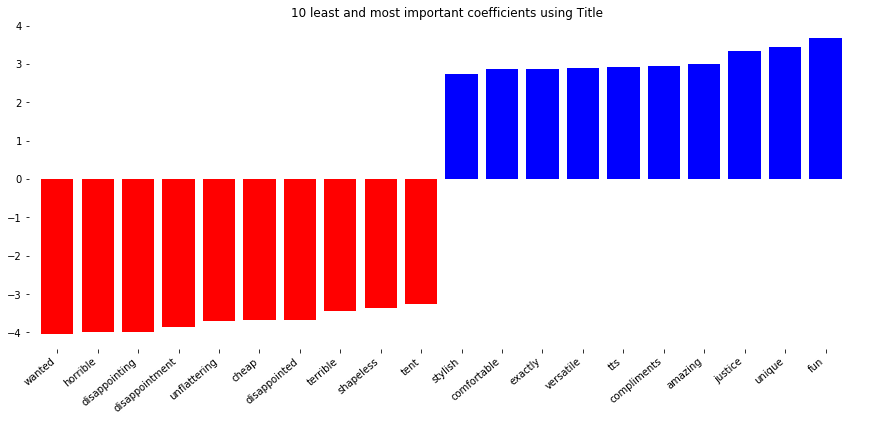

In [28]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title.coef_.ravel(), 
                        np.array(feature_names_title), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients using Title")
plt.show()

In [29]:
cv_title = bow_pipe_title.named_steps['countvectorizer']
X_train_title = cv_title.transform(text_train_title)
X_val_title = cv_title.transform(text_test_title)
lr_title.score(X_val_title, y_test)

0.8827600244249949

In [30]:
print(X_train_title.shape)
print(len(feature_names_title))

(14762, 3219)
3219


#### Evaluation using `Review` field only

In [31]:
%%time
bow_pipe_review = make_pipeline(CountVectorizer(), 
                                LogisticRegressionCV(scoring='roc_auc'))
print(cross_val_score(bow_pipe_review, text_train_review, 
                      y_train, cv=5, scoring='roc_auc'))

[0.92095963 0.9270255  0.9173906  0.92501866 0.92596217]
CPU times: user 1min 11s, sys: 1.33 s, total: 1min 12s
Wall time: 39.9 s


In [32]:
bow_pipe_review.fit(text_train_review,y_train)

lr_review = bow_pipe_review.named_steps['logisticregressioncv']
feature_names_review = np.array(bow_pipe_review
                                .named_steps['countvectorizer']
                                .get_feature_names())

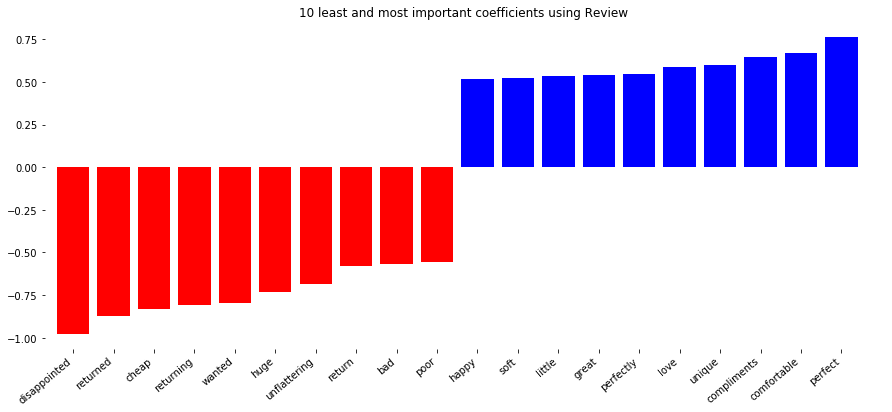

In [33]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_review.coef_.ravel(), 
                        np.array(feature_names_review), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients using Review")
plt.show()

In [34]:
cv_review = bow_pipe_review.named_steps['countvectorizer']
X_train_review = cv_review.transform(text_train_review)
X_val_review = cv_review.transform(text_test_review)
lr_review.score(X_val_review, y_test)

0.8843883574190922

In [35]:
print(X_train_review.shape)
print(len(feature_names_review))

(14762, 12041)
12041


#### Evaluation using `Title` and `Review` fields

In [36]:
%%time
bow_pipe_title_review = make_pipeline(CountVectorizer(), 
                                      LogisticRegressionCV(scoring='roc_auc'))
cross_val_score(bow_pipe_title_review, text_train_title_review, 
                y_train, cv=5, scoring='roc_auc')

CPU times: user 1min 19s, sys: 1.82 s, total: 1min 21s
Wall time: 46.4 s


In [37]:
bow_pipe_title_review.fit(text_train_title_review,y_train)

lr_title_review = bow_pipe_title_review.named_steps['logisticregressioncv']
feature_names_title_review = np.array(bow_pipe_title_review
                                      .named_steps['countvectorizer']
                                      .get_feature_names())

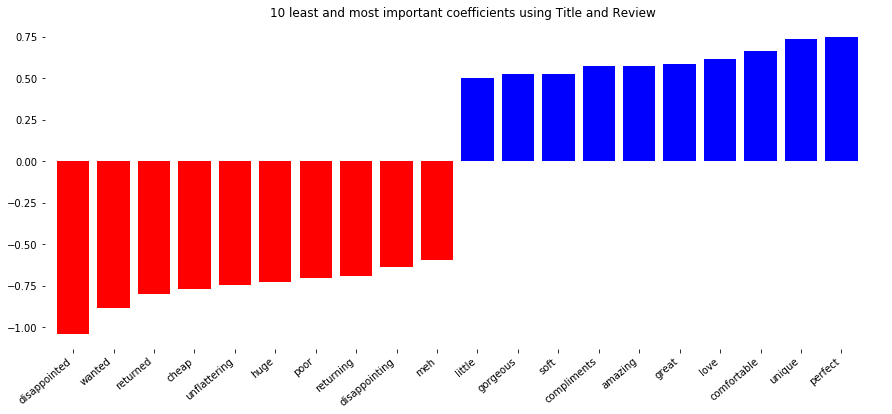

In [38]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title_review.coef_.ravel(), 
                        np.array(feature_names_title_review), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients using Title and Review")
plt.show()

In [39]:
cv_title_review = bow_pipe_title_review.named_steps['countvectorizer']
X_train_title_review = cv_title_review.transform(text_train_title_review)
X_val_title_review = cv_title_review.transform(text_test_title_review)
lr_title_review.score(X_val_title_review, y_test)

0.8963973132505597

In [40]:
print(X_train_title_review.shape)
print(len(feature_names_title_review))

(14762, 12515)
12515


#### Vectorizing `Title` and `Review` individually and concatenating the vector representations

In [41]:
from scipy.sparse import hstack

feature_names_title_new = [feat+"_t" for feat in feature_names_title]
print(feature_names_title_new[:10])

feature_names_review_new = [feat+"_r" for feat in feature_names_review]
print(feature_names_review_new[:10])

['00_t', '10_t', '100_t', '12_t', '14_t', '150_t', '16_t', '16s_t', '1950_t', '1960s_t']
['00_r', '00p_r', '03_r', '03dd_r', '04_r', '06_r', '0dd_r', '0in_r', '0p_r', '0petite_r']


In [42]:
print(X_train_title.shape)
print(X_train_review.shape)
X_train_title_review_concat = hstack([X_train_title,X_train_review])
print(X_train_title_review_concat.shape)

(14762, 3219)
(14762, 12041)
(14762, 15260)


In [43]:
%%time
print(cross_val_score(LogisticRegressionCV(), X_train_title_review_concat, 
                      y_train, cv=5, scoring='roc_auc'))

[0.9454991  0.94365854 0.93439082 0.94418817 0.94631581]
CPU times: user 1min 15s, sys: 1.36 s, total: 1min 16s
Wall time: 39.3 s


In [45]:
feature_names_title_review_concat = feature_names_title_new + \
                                    feature_names_review_new
print(len(feature_names_title_review_concat))

15260


In [46]:
lr_title_review_concat = LogisticRegressionCV(scoring='roc_auc')
lr_title_review_concat.fit(X_train_title_review_concat,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

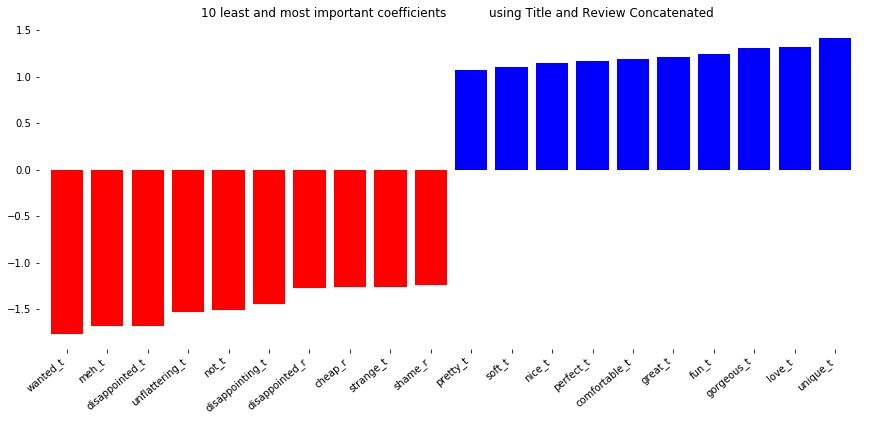

In [47]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title_review_concat.coef_.ravel(), 
                        np.array(feature_names_title_review_concat), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients \
          using Title and Review Concatenated")
plt.show()

In [48]:
print(X_val_title.shape)
print(X_val_review.shape)
X_val_title_review_concat = hstack([X_val_title,X_val_review])
print(X_val_title_review_concat.shape)

(4913, 3219)
(4913, 12041)
(4913, 15260)


In [49]:
lr_title_review_concat.score(X_val_title_review_concat,y_test)

0.9037248117239975

### With GridSearchCV

#### Evaluating using `Title` field only

In [50]:
from sklearn.linear_model import LogisticRegression

In [53]:
%%time
param_grid_lr = {"logisticregression__C": [100, 10, 1, 0.1, 0.001]}
grid_title = GridSearchCV(make_pipeline(CountVectorizer(), 
                                        LogisticRegression()),
                          param_grid=param_grid_lr, cv=5, 
                          scoring="roc_auc")
grid_title.fit(text_train_title,y_train)

print(grid_title.best_score_)
print(grid_title.best_params_)

lr_title_grid = grid_title.best_estimator_.named_steps['logisticregression']
feature_names_title_grid = np.array(grid_title
                                    .best_estimator_
                                    .named_steps['countvectorizer']
                                    .get_feature_names())

0.9204469952584714
{'logisticregression__C': 1}
CPU times: user 5.12 s, sys: 60.5 ms, total: 5.18 s
Wall time: 5.22 s


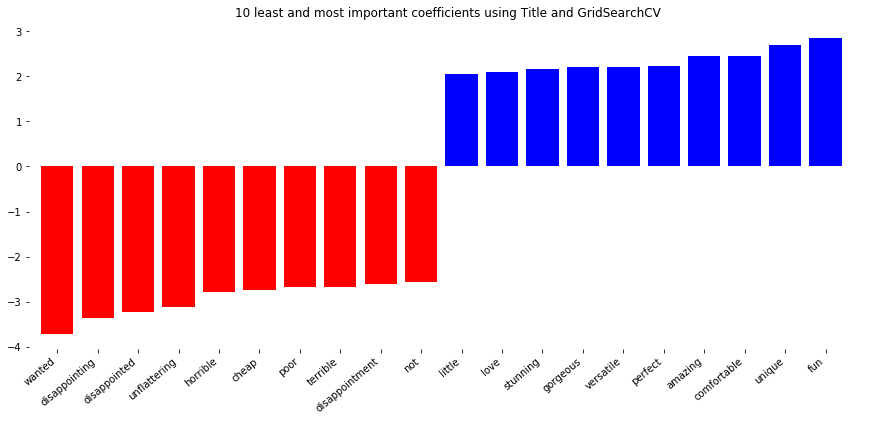

In [54]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title_grid.coef_.ravel(), 
                        np.array(feature_names_title_grid), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients \
using Title and GridSearchCV")
plt.show()

In [55]:
print(grid_title.score(text_test_title,y_test))

0.9214984071094153


#### Evaluating using `Review` field only

In [57]:
%%time
grid_review = GridSearchCV(make_pipeline(CountVectorizer(), 
                                         LogisticRegression()),
                           param_grid=param_grid_lr, cv=5, 
                           scoring="roc_auc")
grid_review.fit(text_train_review,y_train)

print(grid_review.best_score_)
print(grid_review.best_params_)

lr_review_grid = grid_review.best_estimator_.named_steps['logisticregression']
feature_names_review_grid = np.array(grid_review
                                     .best_estimator_
                                     .named_steps['countvectorizer']
                                     .get_feature_names())

0.9237641674362176
{'logisticregression__C': 0.1}
CPU times: user 1min 17s, sys: 1.75 s, total: 1min 19s
Wall time: 57.8 s


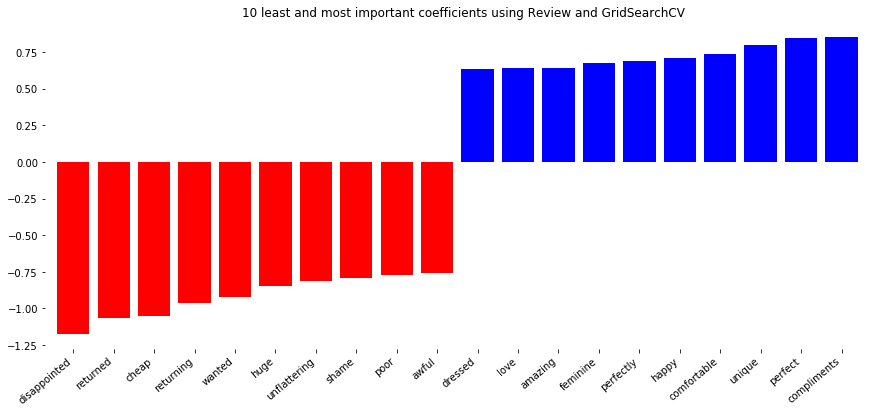

In [58]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_review_grid.coef_.ravel(), 
                        np.array(feature_names_review_grid), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients using \
Review and GridSearchCV")
plt.show()

In [59]:
print(grid_review.score(text_test_review,y_test))

0.9221417324054474


#### Evaluating using `Title` and `Review`

In [60]:
%%time
grid_title_review = GridSearchCV(make_pipeline(CountVectorizer(), 
                                               LogisticRegression()),
                                 param_grid=param_grid_lr, cv=5, 
                                 scoring="roc_auc")
grid_title_review.fit(text_train_title_review,y_train)

print(grid_title_review.best_score_)
print(grid_title_review.best_params_)

lr_title_review_grid = grid_title_review.best_estimator_.named_steps['logisticregression']
feature_names_title_review_grid = np.array(grid_title_review
                                           .best_estimator_
                                           .named_steps['countvectorizer']
                                           .get_feature_names())

0.9424097253719665
{'logisticregression__C': 0.1}
CPU times: user 1min 14s, sys: 1.69 s, total: 1min 16s
Wall time: 56.7 s


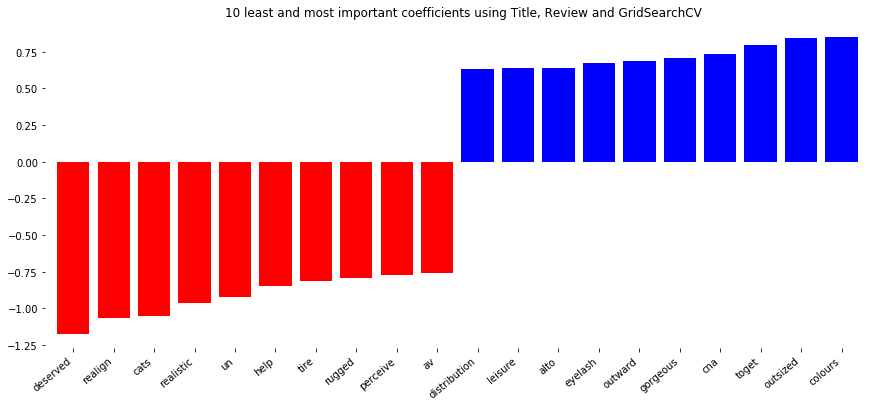

In [61]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_review_grid.coef_.ravel(), 
                        np.array(feature_names_title_review_grid), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients \
using Title, Review and GridSearchCV")
plt.show()

In [62]:
print(grid_title_review.score(text_test_title_review,y_test))

0.9388955774186873


#### Vectorizing `Title` and `Review` individually and concatenating the vector representations

In [63]:
cv_title_grid = grid_title.best_estimator_.named_steps['countvectorizer']
cv_review_grid = grid_review.best_estimator_.named_steps['countvectorizer']
X_train_title_grid = cv_title_grid.transform(text_train_title)
X_train_review_grid = cv_review_grid.transform(text_train_review)
X_train_title_review_concat_grid = hstack([X_train_title_grid,
                                           X_train_review_grid])

X_val_title_grid = cv_title_grid.transform(text_test_title)
X_val_review_grid = cv_review_grid.transform(text_test_review)
X_val_title_review_concat_grid = hstack([X_val_title_grid,
                                         X_val_review_grid])

In [67]:
feature_names_title_grid_new = [feat+"_t" for 
                                feat in feature_names_title_grid]
feature_names_review_grid_new = [feat+"_r" for 
                                 feat in feature_names_review_grid]
feature_names_title_review_concat_grid = feature_names_title_grid_new + \
                                        feature_names_review_grid_new

In [68]:
%%time
param_grid_lr_new = {"C": [100, 10, 1, 0.1, 0.001]}
grid_title_review_concat = GridSearchCV(LogisticRegression(),
                                        param_grid=param_grid_lr_new, 
                                        cv=5, scoring="roc_auc")
grid_title_review_concat.fit(X_train_title_review_concat_grid,y_train)

lr_title_review_grid_concat = grid_title_review_concat.best_estimator_
print(grid_title_review_concat.best_score_)
print(grid_title_review_concat.best_params_)

0.9436040159028604
{'C': 0.1}
CPU times: user 35 s, sys: 966 ms, total: 35.9 s
Wall time: 20.7 s


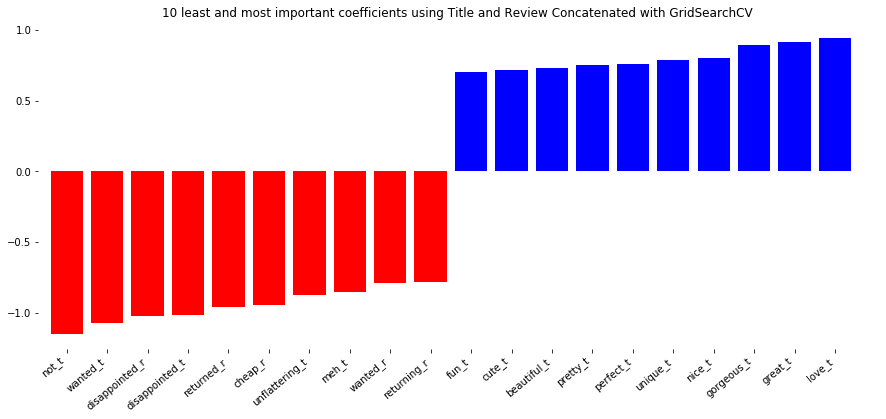

In [69]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title_review_grid_concat.coef_.ravel(), 
                        np.array(feature_names_title_review_concat_grid), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("10 least and most important coefficients using \
Title and Review Concatenated with GridSearchCV")
plt.show()

In [70]:
print(grid_title_review_concat.score(X_val_title_review_concat_grid,
                                     y_test))

0.9431201401345355


The 4th setting which is vectorizing title and reviews individually and concatenating them works the best marginally. The best regularization parameter (C) for this setting is 0.1.

## 3. Feature Tuning

#### Using `TfidfVectorizer` to check its impact on model score and importance coefficients

In [72]:
%%time
param_grid_lr = {"logisticregression__C": [100, 10, 1, 0.1, 0.001]}
grid_tfidf = GridSearchCV(make_pipeline(TfidfVectorizer(), 
                                        LogisticRegression()),
                          param_grid=param_grid_lr, cv=5, 
                          scoring="roc_auc")
grid_tfidf.fit(text_train_title_review,y_train)

print(grid_tfidf.best_score_)
print(grid_tfidf.best_params_)

lr_tfidf = grid_tfidf.best_estimator_.named_steps['logisticregression']
feature_names_tfidf = np.array(grid_tfidf.best_estimator_
                               .named_steps['tfidfvectorizer']
                               .get_feature_names())

0.9498551621199149
{'logisticregression__C': 1}
CPU times: user 48 s, sys: 1.23 s, total: 49.2 s
Wall time: 42.5 s


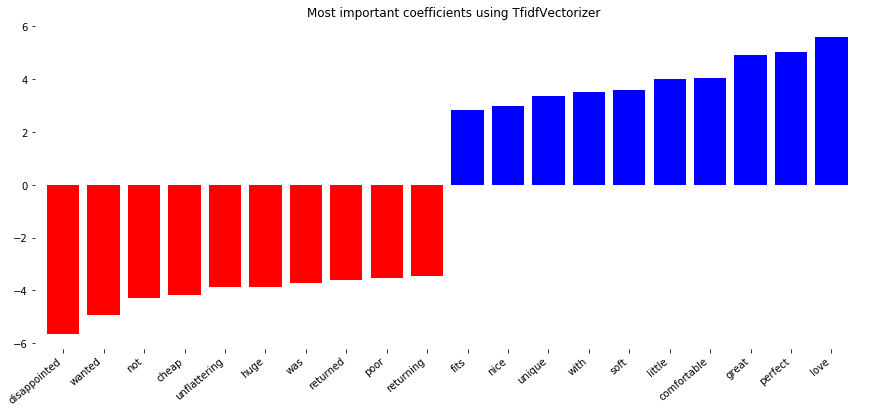

In [73]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf.coef_.ravel(), 
                        np.array(feature_names_tfidf), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using TfidfVectorizer")
plt.show()

In [74]:
print(grid_tfidf.score(text_test_title_review,y_test))

0.9454635538445706


Using the TfidfVectorizer increases the test score to 0.945. Some of the important coefficients remain the same but the majority are changed.

####  Using a `CountVectorizer` with `Normalizer` to check impact on model performance

In [77]:
grid_countvect_normalized = GridSearchCV(make_pipeline(CountVectorizer(), 
                                                       Normalizer(), 
                                                       LogisticRegression()),
                                         param_grid=param_grid_lr, cv=5, 
                                         scoring="roc_auc")
grid_countvect_normalized.fit(text_train_title_review,
                              y_train)

print(grid_countvect_normalized.best_score_)
print(grid_countvect_normalized.best_params_)

lr_countvect_normalized = grid_countvect_normalized\
.best_estimator_\
.named_steps['logisticregression']
feature_names_countvect_normalized = np.array(grid_countvect_normalized
                                              .best_estimator_
                                              .named_steps['countvectorizer']
                                              .get_feature_names())

0.9476031785092168
{'logisticregression__C': 10}


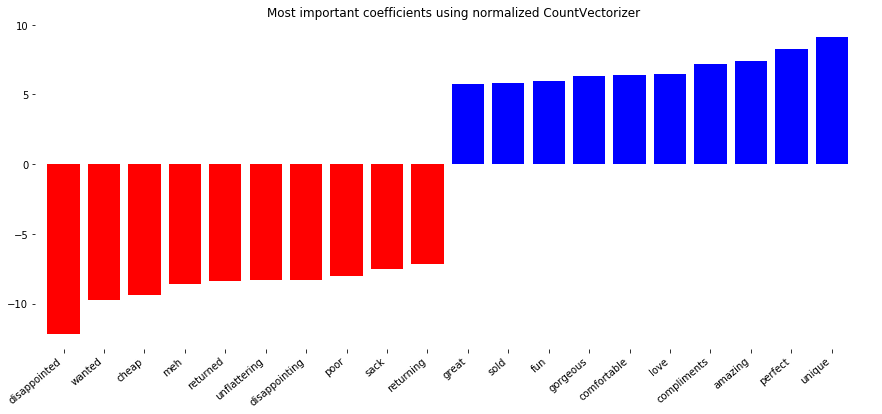

In [78]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_countvect_normalized.coef_.ravel(), 
                        np.array(feature_names_countvect_normalized), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using \
normalized CountVectorizer")
plt.show()

In [79]:
print(grid_countvect_normalized.score(text_test_title_review,
                                      y_test))

0.9441320876438387


Using a Normalizer with CountVectorizer gives a worse performance than using a TfidfVectorizer but the performance improves compared to just using the CountVectorizer without the Normalizer.

#### Removing `Stop Words` and checking impact on number of features and model performance

In [81]:
%%time
grid_tfidf_stop = GridSearchCV(make_pipeline(TfidfVectorizer(stop_words = 
                                                             'english'), 
                                             LogisticRegression()),
                               param_grid=param_grid_lr, cv=5, 
                               scoring="roc_auc")
grid_tfidf_stop.fit(text_train_title_review,y_train)

print(grid_tfidf_stop.best_score_)
print(grid_tfidf_stop.best_params_)

lr_tfidf_stop = grid_tfidf_stop.best_estimator_.named_steps['logisticregression']
feature_names_tfidf_stop = np.array(grid_tfidf_stop
                                    .best_estimator_
                                    .named_steps['tfidfvectorizer']
                                    .get_feature_names())

0.9434995623247132
{'logisticregression__C': 1}
CPU times: user 40.4 s, sys: 805 ms, total: 41.2 s
Wall time: 35.9 s


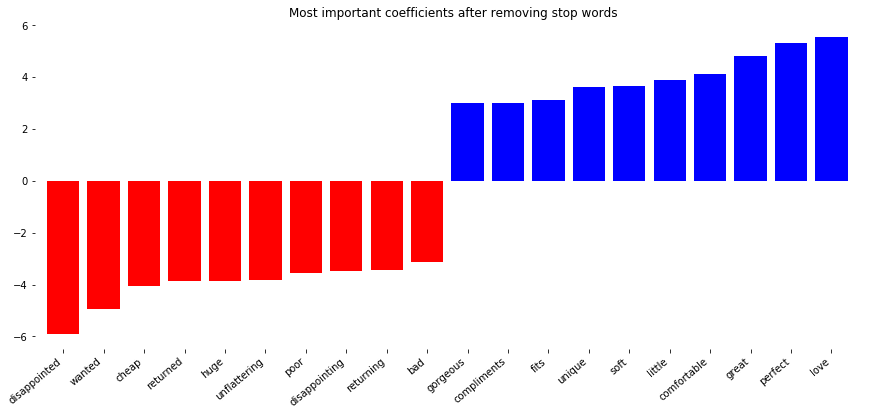

In [82]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_stop.coef_.ravel(), 
                        np.array(feature_names_tfidf_stop), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients after removing stop words")
plt.show()

In [83]:
print(grid_tfidf_stop.score(text_test_title_review,y_test))

0.9397407112735047


Standard english words as stop words don't help with the performance of the model. This is because stop words, by definition, are the most common words in english language and they will very likely be present across most documents. Since TfidfVectorizer is being used, the stop words will have less importance and hence removing them shouldn't affect the performance of the model too much. Another reason is that the total number of stop words are insignicant compared to total number of tokens.

#### Limiting Vocabulary using `min_df` or `max_df`

In [85]:
%%time
param_grid_lr_vocab = {"logisticregression__C": [100, 10, 1, 0.1, 0.001],
                       "tfidfvectorizer__min_df": [0.00001, 0.0001, 0.001],
                       "tfidfvectorizer__max_df": [0.5, 0.6, 0.7],
                      }

#using pipeline memory option to decrease grid-search run-time 
grid_tfidf_vocab = GridSearchCV(make_pipeline(TfidfVectorizer(), 
                                              LogisticRegression(), 
                                              memory = 'cache_folder'),
                                param_grid=param_grid_lr_vocab, cv=5,
                                scoring="roc_auc", n_jobs = -1)
grid_tfidf_vocab.fit(text_train_title_review,y_train)

print(grid_tfidf_vocab.best_score_)
print(grid_tfidf_vocab.best_params_)

lr_tfidf_vocab = grid_tfidf_vocab.best_estimator_.named_steps['logisticregression']
feature_names_tfidf_vocab = np.array(grid_tfidf_vocab
                                     .best_estimator_
                                     .named_steps['tfidfvectorizer']
                                     .get_feature_names())

0.9503769994060268
{'logisticregression__C': 1, 'tfidfvectorizer__max_df': 0.6, 'tfidfvectorizer__min_df': 0.0001}
CPU times: user 4.26 s, sys: 2.15 s, total: 6.41 s
Wall time: 2min 45s


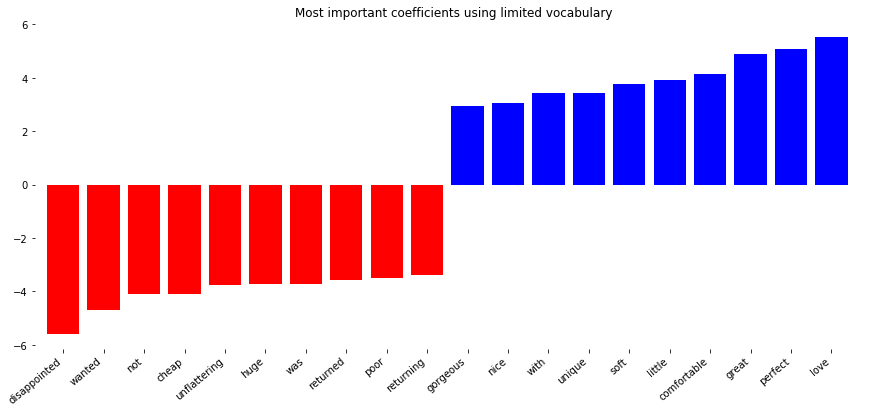

In [86]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_vocab.coef_.ravel(), 
                        np.array(feature_names_tfidf_vocab), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using limited vocabulary")
plt.show()

In [87]:
print(grid_tfidf_vocab.score(text_test_title_review,y_test))

0.9460682879220274


In [88]:
print(len(feature_names_tfidf), len(feature_names_tfidf_vocab))

12515 7176


The number of features are decreased from 12515 to 7176 after using min_df = 0.0001 and max_df = 0.6 with the tfidf vectorizer. The score was improved by a significant amount after limiting vocabulary. 

## 4. Using `n-grams` and assesing impact

#### Using current best model, changing from `unigrams` to `n-grams` of varying length 

In [89]:
%%time
param_grid_lr_ngrams = {"tfidfvectorizer__ngram_range": [(1,2), 
                                                         (1,3), 
                                                         (2,3)]}


grid_tfidf_ngrams = GridSearchCV(make_pipeline(TfidfVectorizer(max_df = 0.6, 
                                                               min_df = 0.0001), 
                                               LogisticRegression(C = 1), 
                                               memory = 'cache_folder'),
                                param_grid=param_grid_lr_ngrams, cv=5,
                                scoring="roc_auc", n_jobs = -1)
grid_tfidf_ngrams.fit(text_train_title_review,y_train)

print(grid_tfidf_ngrams.best_score_)
print(grid_tfidf_ngrams.best_params_)

lr_tfidf_ngrams = grid_tfidf_ngrams.best_estimator_.\
named_steps['logisticregression']
feature_names_tfidf_ngrams = np.array(grid_tfidf_ngrams.
                                      best_estimator_.
                                      named_steps['tfidfvectorizer'].
                                      get_feature_names())

0.9534868951199252
{'tfidfvectorizer__ngram_range': (1, 2)}
CPU times: user 6.76 s, sys: 510 ms, total: 7.27 s
Wall time: 1min 35s


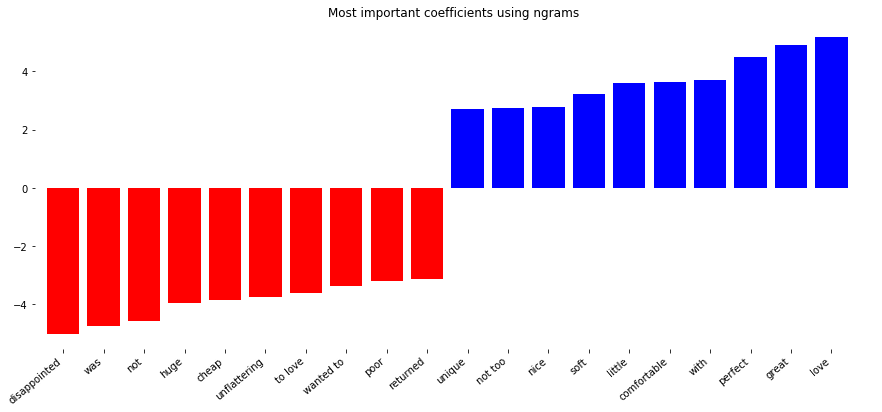

In [90]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_ngrams.coef_.ravel(), 
                        np.array(feature_names_tfidf_ngrams), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using ngrams")
plt.show()

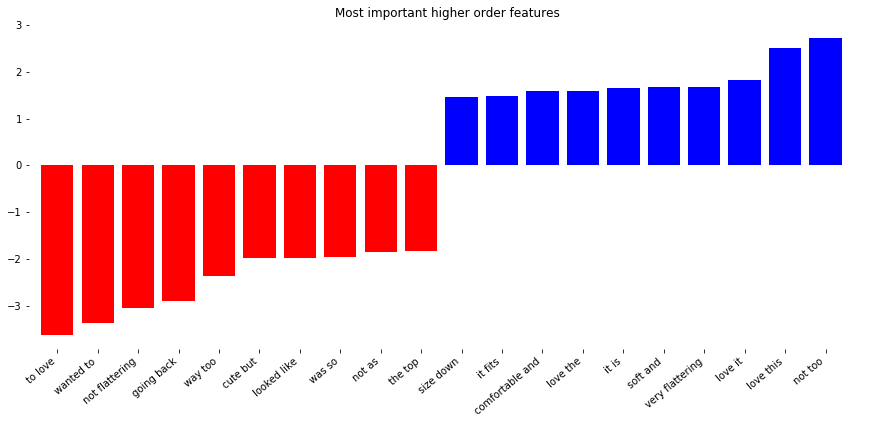

In [91]:
features = pd.Series(feature_names_tfidf_ngrams)

plt.figure(figsize=(15, 6))
plot_important_features(np.array(pd.Series(lr_tfidf_ngrams
                                           .coef_.ravel())[features\
                                                           .str
                                                           .contains(' ')]), 
                        np.array(features[features.str.contains(' ')]), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important higher order features")
plt.show()

In [92]:
print(grid_tfidf_ngrams.score(text_test_title_review,y_test))

0.9518813149895486


The best performance is given my ngram_range = (1,2) with a test score of 0.952.

#### Using character `n-grams` and assesing impact

In [93]:
%%time
param_grid_lr_ngrams = {"tfidfvectorizer__ngram_range": [(2,5), 
                                                         (3,4), 
                                                         (3,5)]}


grid_tfidf_ngrams_char = GridSearchCV(make_pipeline(TfidfVectorizer(max_df = 0.6, 
                                                                    min_df = 0.0001, 
                                                                    analyzer = 'char_wb'), 
                                                    LogisticRegression(C = 1), 
                                                    memory = 'cache_folder'),
                                      param_grid=param_grid_lr_ngrams, 
                                      cv=5,scoring="roc_auc", n_jobs = -1)

grid_tfidf_ngrams_char.fit(text_train_title_review,y_train)

print(grid_tfidf_ngrams_char.best_score_)
print(grid_tfidf_ngrams_char.best_params_)

lr_tfidf_ngrams_char = grid_tfidf_ngrams_char.best_estimator_\
.named_steps['logisticregression']
feature_names_tfidf_ngrams_char = np.array(grid_tfidf_ngrams_char
                                           .best_estimator_
                                           .named_steps['tfidfvectorizer']
                                           .get_feature_names())

0.9495127385389969
{'tfidfvectorizer__ngram_range': (3, 5)}
CPU times: user 15 s, sys: 991 ms, total: 16 s
Wall time: 3min 9s


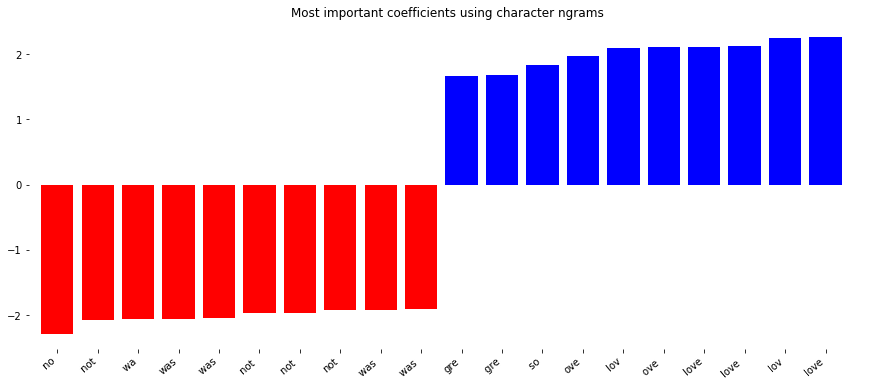

In [94]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_ngrams_char.coef_.ravel(), 
                        np.array(feature_names_tfidf_ngrams_char), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using character ngrams")
plt.show()

In [95]:
print(grid_tfidf_ngrams_char.score(text_test_title_review,y_test))

0.9449816477316109


Even after using character n-grams, it is observed that most important features are usually whole words and they are similar to the features in word n-gram. `char_wb` is the analyzer used so as to respect the word boundaries of the character windows.

#### Investigating impact of `stop words` and `min-df` on word `n-grams` 

In [98]:
param_grid_lr_ngrams = {"tfidfvectorizer__min_df": [0.00001, 
                                                    0.0001, 
                                                    0.001, 
                                                    0.1],
                       "tfidfvectorizer__stop_words": ['english', 
                                                       None]}

grid_tfidf_ngrams = GridSearchCV(make_pipeline(TfidfVectorizer(max_df = 0.6, 
                                                               ngram_range = (1,2)), 
                                               LogisticRegression(C = 1), 
                                               memory = 'cache_folder'),
                                param_grid=param_grid_lr_ngrams, cv=5,
                                 scoring="roc_auc", n_jobs = -1)
grid_tfidf_ngrams.fit(text_train_title_review,y_train)

print(grid_tfidf_ngrams.best_score_)
print(grid_tfidf_ngrams.best_params_)

lr_tfidf_ngrams = grid_tfidf_ngrams.best_estimator_\
.named_steps['logisticregression']
feature_names_tfidf_ngrams = np.array(grid_tfidf_ngrams
                                      .best_estimator_
                                      .named_steps['tfidfvectorizer']
                                      .get_feature_names())

0.9539853060627546
{'tfidfvectorizer__min_df': 0.001, 'tfidfvectorizer__stop_words': None}


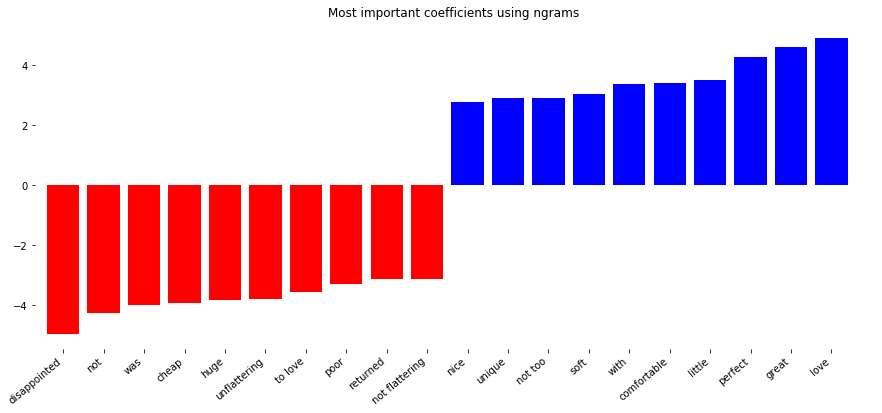

In [99]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_ngrams.coef_.ravel(), 
                        np.array(feature_names_tfidf_ngrams), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using ngrams")
plt.show()

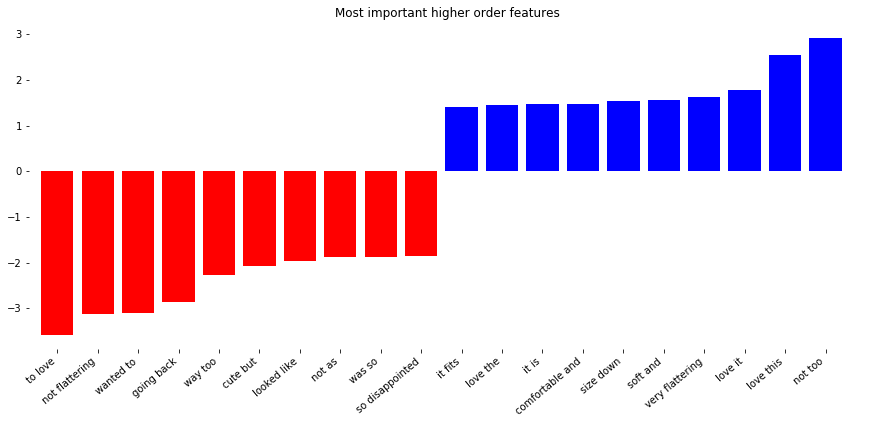

In [100]:
features = pd.Series(feature_names_tfidf_ngrams)

plt.figure(figsize=(15, 6))
plot_important_features(np.array(pd.Series(lr_tfidf_ngrams.coef_.ravel())[features.str.contains(' ')]), 
                        np.array(features[features.str.contains(' ')]), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important higher order features")
plt.show()

In [101]:
print(grid_tfidf_ngrams.score(text_test_title_review,y_test))

0.9523242149245934


In [102]:
len(features)

10220

Removing stop words gives a slightly worse performance than keeping them. And the min_df = 0.001 gives the best score. The test score improved from 0.9518 to 0.9523. The total number of features are reduced from 12515 to 10220 after applying these transformations.

## 5. Comparing L1 and L2 penalty on best model from previous step

In [104]:
param_grid_lr_ngrams = {"logisticregression__penalty": ['l1', 
                                                        'l2'],
                       "logisticregression__C": [0.001, 
                                                 0.01, 
                                                 0.1, 
                                                 1, 
                                                 10, 
                                                 100]}

grid_tfidf_final = GridSearchCV(make_pipeline(TfidfVectorizer(max_df = 0.6, 
                                                              min_df = 0.001, 
                                                              ngram_range = (1,2)), 
                                               LogisticRegression(), 
                                              memory = 'cache_folder'),
                                param_grid=param_grid_lr_ngrams, 
                                cv=5,scoring="roc_auc", n_jobs = -1)
grid_tfidf_final.fit(text_train_title_review,y_train)

print(grid_tfidf_final.best_score_)
print(grid_tfidf_final.best_params_)

lr_tfidf_final = grid_tfidf_final.best_estimator_\
.named_steps['logisticregression']
feature_names_tfidf_final = np.array(grid_tfidf_final
                                     .best_estimator_
                                     .named_steps['tfidfvectorizer']
                                     .get_feature_names())

0.9539853060627546
{'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}


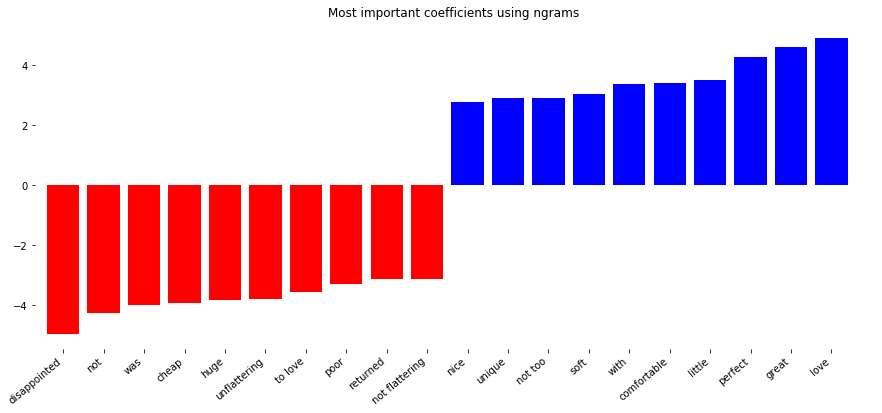

In [105]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_final.coef_.ravel(), 
                        np.array(feature_names_tfidf_final), 
                        top_n=10, rotation=40)
ax = plt.gca()
plt.title("Most important coefficients using ngrams")
plt.show()

In [106]:
print(grid_tfidf_final.score(text_test_title_review,y_test))

0.9523242149245934


l2 penalty is better than l1 penalty for this model. Different regularization parameters are tried and it is found that `C`=0.1 is the best performing regularization parameter.

Other features that can be tried are:
- Length of text
- Number of *out-of-vocabulary* words
- Using *sentiment* words
- Presence and *frequency* of all *upper-case* words
- Taking punctuation into account with character n-grams